# Analysis Of TYBSC-CS Marksheet 

### Converting Text Records to CSV

##### Steps: 
1. Convert the PDF of Marksheet to Text File.
    + Either use this https://avepdf.com/en/pdf-to-text
    + Or Select Entire PDF and Paste it in a Notepad.
2. Each New Record begins with a 7 digit unique number, which marks the start of new record
3. regex: `r"[\d]{7}"` is used to find this. A match would indicate a new record's start. Name is the portion after 7 digits and before the `(` left paranthesis.
4. College is in the form of some-digits :(colon) COLLEGE_NAME UNTIL END OF LINE.
5. For SGPA and FINAL CGPA we use simple REGEX to match and pick the first matched record, split it by ':' giving use SGP# and ## pointer.
6. However for SEM 6 Result is quite tricky. There is a pattern, which is, the end of line of 6th line starting from the Start of record (i.e. unique 7 digits number and name). It either has pointer of `--` indicating absence, in case of `#` sign, simply take the third last element - which is done in program recursively.

NOTE: **WE SAVE THE DATA TO CSV FOR MANUAL MINOR FIXES FROM EXCELL**

In [121]:
import re
from tqdm.notebook import tqdm
import seaborn as sns

# Make sure not to set REGEX to multi-line

inital_digits = r"[\d]{7}"
regex_final_cgpa = r"(CGPI)\s+:\s+([\d.]*)"
regex_sgp1 = r"(SEM\-I)\s+:\s+([\d\.]*)"
regex_sgp2 = r"(SEM\-II)\s+:\s+([\d\.]*)"
regex_sgp3 = r"(SEM\-III)\s+:\s+([\d\.]*)"
regex_sgp4 = r"(SEM\-IV)\s+:\s+([\d\.]*)"
regex_sgp5 = r"(SEM\-V)\s+:\s+([\d\.]*)"
regex_sgp6 = r"(SEM\-VI)\s+:\s+([\d\.]*)"
regex_name = r"[\d]{7}\s?([\W\w*]+?)(?=[\(])" # Strip the captured group
regex_college = r"\s+[\d]{1,4}:(.*)" # Capture group for college name

FILE_PATH = "Bsc-IT-Results.txt"
# FILE_PATH = "IT-sample.txt"

all_students = []

def extract_name(line):
    try:        
        g1 = re.findall(regex_name, line)[0].strip()
        g1 = g1[1:] if g1.startswith('/') else g1
        return g1
    except:
        print()

def extract_college(line):
    try:
        college_name = re.findall(regex_college,line)        
        if(len(college_name) > 0):            
            return ' '.join(college_name[0].strip().split())
    except:
        return None

def get_first_match(regex,line,student):
    match = re.findall(regex, line)
    try:    
        if(match != None and len(match) != 0): 
            match_first = match[0]
            sem = match_first[0]
            gpa = match_first[-1]  
            try:
                float_gpa = float(gpa)
                student[sem] = float_gpa if float_gpa != 0 else None
            except:                
                student[sem] = None
    except:
        print(f'Failed match GPA at {line}')
        
def get_sem6_gpa(line_list):
    last_obj = line_list[-1]
    if(last_obj == '--'):
        return None
    elif(last_obj.startswith('#')):
        return get_sem6_gpa(line_list[0:-1])
    else:
        return float(last_obj)
    
    
line_number = None
with open(FILE_PATH) as file:
    next_line_is_college = False
    # doc_text = ''.join(file.readlines())
    prev_student = None
    for line in tqdm(file.readlines()):
        # filter heading text    
        if(re.search(inital_digits, line) or prev_student):
            obj = re.search(inital_digits, line)            
            # update name
            if(obj != None):
                line_number = 1
                name = extract_name(line)
                if(prev_student != None):
                    all_students.append(prev_student)             
                prev_student = dict()
                prev_student['name'] = name          
                prev_student['college_name'] = extract_college(line)
                continue
            line_number += 1
            # Sem 6 pointer
            if(line_number == 6): 
                prev_student['SEM-VI'] = get_sem6_gpa(line.split())
                                        
                                
            get_first_match(regex_sgp1,line,prev_student)
            get_first_match(regex_sgp2,line,prev_student)
            get_first_match(regex_sgp3,line,prev_student)
            get_first_match(regex_sgp4,line,prev_student)
            get_first_match(regex_sgp5,line,prev_student)
            get_first_match(regex_sgp6,line,prev_student)
            get_first_match(regex_final_cgpa,line,prev_student)    

            
# len(all_students)
# all_students

In [140]:
import pandas as pd


df = pd.DataFrame.from_dict(all_students)
df = df.rename(columns={'SEM-I':"SGP1", 'SEM-II':'SGP2', 'SEM-III':'SGP3', 'SEM-IV':'SGP4', 'SEM-V':'SGP5','SEM-VI':'SGP6',
       'CGPI':'CGPA'})
df.to_csv("marks-IT.csv",index=False)

### Helper Functions

In [119]:
from IPython.core.display import display, HTML
import seaborn as sns
def print_full(x):
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')
    
def print_title(s):
    display(HTML(f"<h3>{s}</h3>"))

def print_caption(s):
    display(HTML(f"<h6>{s}</h6>"))
    
def print_seperator():
    print_title("-"*100)
    

def highlight_value(tdf):
    style_func = lambda c : ['background: lightgreen' if x == "RUPAREL" else '' for x in c]
    return tdf.style.apply(style_func,axis=0)

### Preprocessing Problems

+ Remove '/' prefix
+ Correct Incorrect College Names
+ Map College prefix to Full Name
+ Update Dtype of Pointer Cols

In [141]:
"""Manually fixed wrong college names from Excell"""
df = pd.read_csv("marks-IT.csv")

In [104]:
""" Removing '/' prefix """

func = lambda c: c[1:] if c.startswith('/') else c
df['name'] = df['name'].apply(func)

# Analysis

## Ruparel

In [134]:
COLLEGE_NAME = 'D. G. Ruparel College of Arts, Science a'

#### Top by GPA

In [142]:
from IPython.core.display import HTML

sgp_to_sem_map = {"SGP1":'Semester 1', 'SGP2':'Semester 2',
                  'SGP3': 'Semester 3', 'SGP4':'Semester 4',
                  'SGP5':'Semester 5','SGP6':'Semester 6',
                 'CGPA': 'Final CGPA'}

ruparel_df = df[df['college_name'] == COLLEGE_NAME]

res_cgpa = ruparel_df.sort_values(by='CGPA',ascending=False).head(10).reset_index()


def display_top_student_by_col(col):
    print_title(f"Top 10 Students - {sgp_to_sem_map[col]}")
    res = ruparel_df.sort_values(by=col,ascending=False).head(10).reset_index().loc[:,['name',col]]
    display(res.loc[:,['name',col]])

for s in sgp_to_sem_map.keys():
    display_top_student_by_col(s)
    print_title('-'*100)
    
res_lowest_cgpa = ruparel_df.sort_values(by="CGPA",ascending=True).head(10).reset_index().loc[:,['name','CGPA']]
print_title("Lowest by CGPA")
display(res_lowest_cgpa)

,name,SGP1
0,SAWANT OMKAR VIJAY LAXMI,9.4
1,JOSHI NISHANT HARISHCHANDRA HEMANGI,9.4
2,CHOUGULE FARHEEN SALIM NASREEN,9.4
3,PALVE PRAJAKTA DHANANJAY SUREKHA,9.4
4,PATHAN ARMAAN ABDUL RAHIM AMINA,9.0
5,SINGH SAURABH JAYPRAKASH SUNITA,9.0
6,BANDAMINI RAVI RAMLU LAXMI,9.0
7,MODI SHUBHAM GANESH SUSHAMA,8.9
8,ASWAL NAROTTAM PREMCHAND VAISHNODEVI,8.9
9,RANE SHIVANI VIJAY MANALI,8.9


,name,SGP2
0,SINGH SAURABH JAYPRAKASH SUNITA,9.8
1,CHOUGULE FARHEEN SALIM NASREEN,9.7
2,SAWANT OMKAR VIJAY LAXMI,9.6
3,JOSHI NISHANT HARISHCHANDRA HEMANGI,9.6
4,ASWAL NAROTTAM PREMCHAND VAISHNODEVI,9.5
5,RANE SHIVANI VIJAY MANALI,9.4
6,YADAV SIMRAN VYASMUNI INDRAVATIDEVI,9.3
7,AITHAL SHRIRAKSHA NAGARAJA ANURADHA,9.2
8,MODI SHUBHAM GANESH SUSHAMA,9.2
9,JUNJUR PAVITRA GANGARAJAM SUJATA,9.2


,name,SGP3
0,GAWDE SNEHAL LAXMAN SANCHITA,9.3
1,JOSHI NISHANT HARISHCHANDRA HEMANGI,9.2
2,PATHAN ARMAAN ABDUL RAHIM AMINA,9.2
3,SAWANT OMKAR VIJAY LAXMI,9.1
4,ANJARLEKAR RIDDHI RAVINDRA RAJASHREE,9.0
5,RANE SHIVANI VIJAY MANALI,9.0
6,YADAV KARAN CHHEDI LAILA,8.8
7,SINGH SAURABH JAYPRAKASH SUNITA,8.8
8,PATIL SHANTANU AMOL SUNITA,8.7
9,AITHAL SHRIRAKSHA NAGARAJA ANURADHA,8.7


,name,SGP4
0,GAWDE SNEHAL LAXMAN SANCHITA,9.4
1,ANJARLEKAR RIDDHI RAVINDRA RAJASHREE,9.3
2,SAWANT OMKAR VIJAY LAXMI,9.3
3,JOSHI NISHANT HARISHCHANDRA HEMANGI,9.2
4,CHOUGULE FARHEEN SALIM NASREEN,9.2
5,YADAV SIMRAN VYASMUNI INDRAVATIDEVI,9.1
6,SINGH SAURABH JAYPRAKASH SUNITA,9.1
7,PATIL SHANTANU AMOL SUNITA,9.0
8,PATHAN ARMAAN ABDUL RAHIM AMINA,8.9
9,KAMBLE SHUBHAM CHANDRAKANT SUNITA,8.8


,name,SGP5
0,WAGHMARE KAUSTUBH SANJAY KUSUM,9.1
1,SINGH SAURABH JAYPRAKASH SUNITA,9.1
2,JOSHI NISHANT HARISHCHANDRA HEMANGI,9.1
3,MODI SHUBHAM GANESH SUSHAMA,9.0
4,ANJARLEKAR RIDDHI RAVINDRA RAJASHREE,9.0
5,YADAV SIMRAN VYASMUNI INDRAVATIDEVI,9.0
6,WANI VAISHNAVI RAMESH SUJATA,8.9
7,WAGHILKAR SHUBHAM SANJAY SHEETAL,8.8
8,TALEKAR SHRUTIKA ARUN ARCHANA,8.8
9,JUNJUR PAVITRA GANGARAJAM SUJATA,8.7


,name,SGP6
0,SINGH SAURABH JAYPRAKASH SUNITA,9.8
1,SAWANT OMKAR VIJAY LAXMI,9.8
2,PATHAN ARMAAN ABDUL RAHIM AMINA,9.8
3,CHOUGULE FARHEEN SALIM NASREEN,9.8
4,MODI SHUBHAM GANESH SUSHAMA,9.8
5,KADAM MANALI RAVIKANT ASAWARI,9.7
6,ANJARLEKAR RIDDHI RAVINDRA RAJASHREE,9.6
7,WAGHILKAR SHUBHAM SANJAY SHEETAL,9.6
8,YADAV SIMRAN VYASMUNI INDRAVATIDEVI,9.6
9,JAGADALE ANKITA ARUN ASHA,9.6


,name,CGPA
0,SAWANT OMKAR VIJAY LAXMI,9.30
1,JOSHI NISHANT HARISHCHANDRA HEMANGI,9.28
2,SINGH SAURABH JAYPRAKASH SUNITA,9.27
3,CHOUGULE FARHEEN SALIM NASREEN,9.22
4,ANJARLEKAR RIDDHI RAVINDRA RAJASHREE,9.12
5,PATHAN ARMAAN ABDUL RAHIM AMINA,9.08
6,YADAV SIMRAN VYASMUNI INDRAVATIDEVI,9.08
7,GAWDE SNEHAL LAXMAN SANCHITA,8.95
8,MODI SHUBHAM GANESH SUSHAMA,8.90
9,ASWAL NAROTTAM PREMCHAND VAISHNODEVI,8.90


,name,CGPA
0,ADEKAR SIDDHESH RAMESH RIMA,5.95
1,VORA TRUSHIT RAJESH BHARTI,6.03
2,PATWA JYOTIKUMARI PRAHLAD PRASAD KANTIDEVI,6.33
3,BHOSALE RUCHITA SATISH MANISHA,6.35
4,MORE ABHISHEK VASANT VAISHALI,6.37
5,GAIKWAD SANMIT SANJAY SANJANA,6.38
6,GAWADE SUSMITA HARISHCHANDRA AMRUTA,6.45
7,KULYE MUKESH SAKHARAM SEJAL,6.58
8,BAGAL SHRUTIKA SHRIKANT UJJWALA,6.60
9,MANE OMKAR YASHWANT MANISHA,6.60


#### Visualization

,Semester,Means
0,SGP6,8.546087
1,SGP1,7.266071
2,SGP2,7.090179
3,SGP3,7.287619
4,SGP4,7.563866
5,SGP5,7.499138
6,CGPA,7.639579


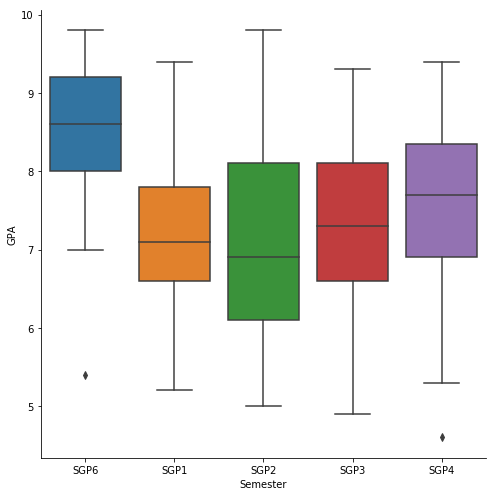

In [143]:
means = ruparel_df.mean()
df_rmeans = pd.DataFrame({'Semester':means.index,'Means':means.values})
all_gpas_metled = pd.melt(ruparel_df.iloc[:,[2,3,4,5,6]],var_name="Semester",value_name="GPA")

print_caption('SGP1 = Semester 1 and so on...')
print_seperator()
print_title("Mean GPA accross all Sems")
display(df_rmeans)

print_seperator()

print_title("Box Plot of Variation in GPA's")
_ = sns.catplot(x='Semester',y='GPA',data=all_gpas_metled,kind='box',height=7)

SGP1    7 
SGP2    7 
SGP3    14
SGP4    0 
SGP5    3 
SGP6    4 
CGPA    24
dtype: int64

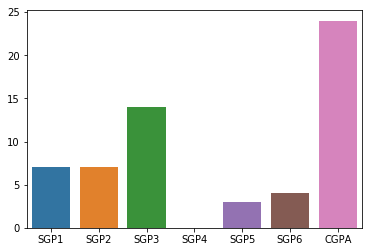

In [233]:
print_title("Number of Records without GPA (Indicating Failed or KT or Some Error in report)")

n_fail = dict()
for sem in sgp_to_sem_map.keys():
    n_fail[sem] = 119 - ruparel_df[sem].count()
series_fail = pd.Series(n_fail)
display(series_fail)
sns.barplot(series_fail.index,series_fail.values)


## Inter-College Comparisions

In [146]:
print_title("Table of : Top 20 Colleges with highest Student Count")
pd.set_option('display.max_rows', 100)
_x = df.groupby(by='college_name')
# Remove colleges with less then 10 students
colleges_df = _x.filter(lambda x: len(x) > 10)
all_colleges_count = colleges_df.groupby(by='college_name')['college_name'].count().sort_values(ascending=False)
all_colleges_count = pd.DataFrame({"College Name": all_colleges_count.index,'Student Count': all_colleges_count.values})
highlight_value(all_colleges_count.head(20))

,College Name,Student Count
0,Vidyalankar School of Information Techno,308
1,Vishnu Waman Thakur Charitable Trust's V,247
2,Thakur Educational Trust's Thakur Colleg,201
3,Shri Shankar Narayan Education Trust's S,147
4,South Indian Education Society's College,136
5,"Bhiwandi Nizampur Nagarpalika Arts, Scie",126
6,Bunts Sangha's S. M. Shetty College of S,124
7,"D. G. Ruparel College of Arts, Science a",119
8,Valia Chhaganlal Laljibhai College of Co,117
9,Sanpada College of Commerce & Technology,116


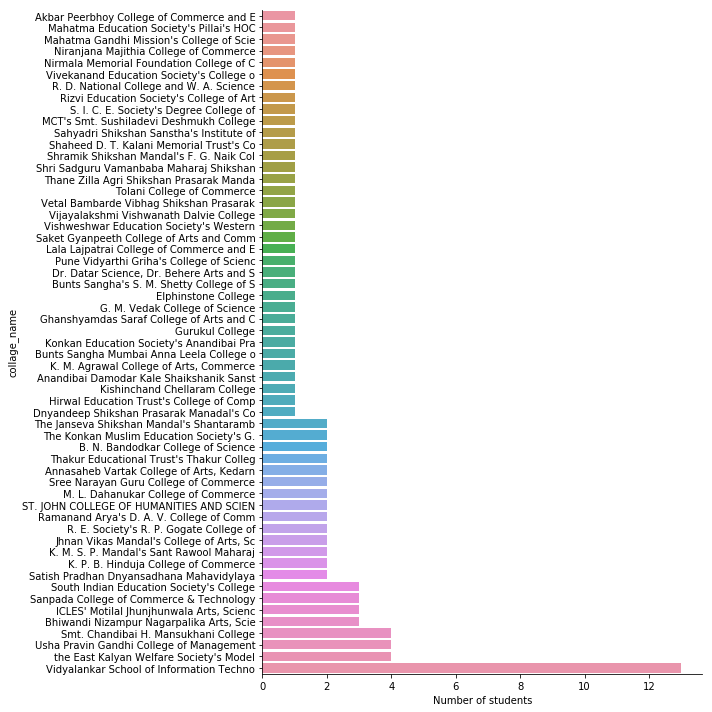

In [147]:
print_title("Top 100 Students(by CGPA) Categorized by College")
top_colleges_by_cgpa = colleges_df.sort_values(by='CGPA',ascending=False).head(100).reset_index()
ts = top_colleges_by_cgpa.groupby(by='college_name').college_name.count().sort_values()
ts = pd.DataFrame({'collage_name':ts.index,'Number of students':ts.values})
g = sns.catplot(y='collage_name',x='Number of students',data=ts,height=10,orient='h',kind='bar')

In [158]:
print_title("Ruparel Students in Top 100")
tcbc = top_colleges_by_cgpa[top_colleges_by_cgpa['college_name'] == 'RUPAREL']
print_full(tcbc)
print_caption(f"{tcbc.CGPA.count()} Students in Top 100")

c:\users\home\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,index,name,college_name,SGP6,SGP1,SGP2,SGP3,SGP4,SGP5,CGPA


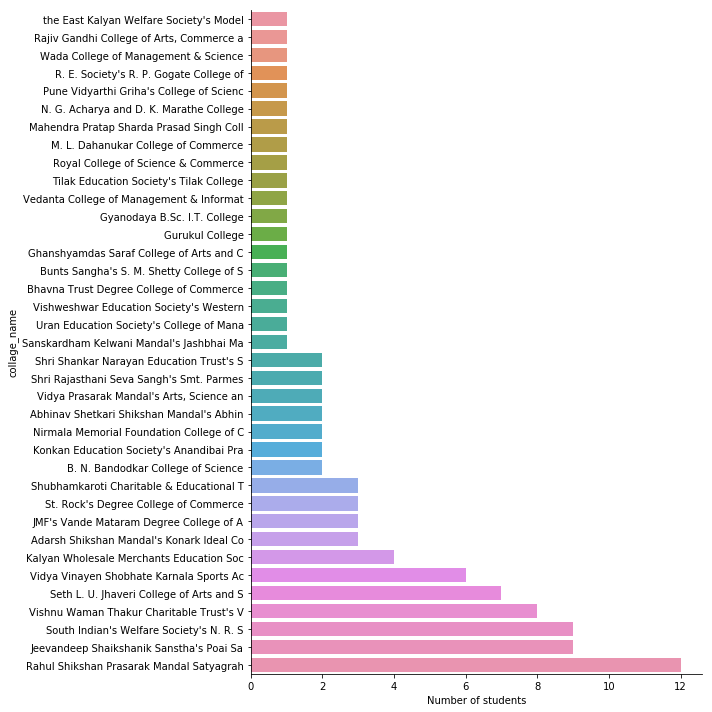

In [149]:
print_title("Lowest 100 Students(by CGPA) Categorized by College")
top_colleges_by_cgpa = colleges_df.sort_values(by='CGPA',ascending=True).head(100).reset_index()
ts = top_colleges_by_cgpa.groupby(by='college_name').college_name.count().sort_values()
ts = pd.DataFrame({'collage_name':ts.index,'Number of students':ts.values})
g = sns.catplot(y='collage_name',x='Number of students',data=ts,height=10,orient='h',kind='bar')

,college_name,CGPA
0,G. M. Vedak College of Science,8.925000
1,"Nalanda Education Foundation, Dr Babasah",8.775000
2,Anandibai Damodar Kale Shaikshanik Sanst,8.515000
3,The Janseva Shikshan Mandal's Shantaramb,8.507000
4,Vijayalakshmi Vishwanath Dalvie College,8.503704
5,Shree Ram Raje College of Hotel & Touris,8.495455
6,K. M. S. P. Mandal's Sant Rawool Maharaj,8.482174
7,"MSG-SGKM College of Arts, Science & Comm",8.472500
8,Shri. Pancham Khemraj Mahavidyalaya,8.466000
9,Vishwabhushan Bharatratna Dr. Babasaheb,8.461429


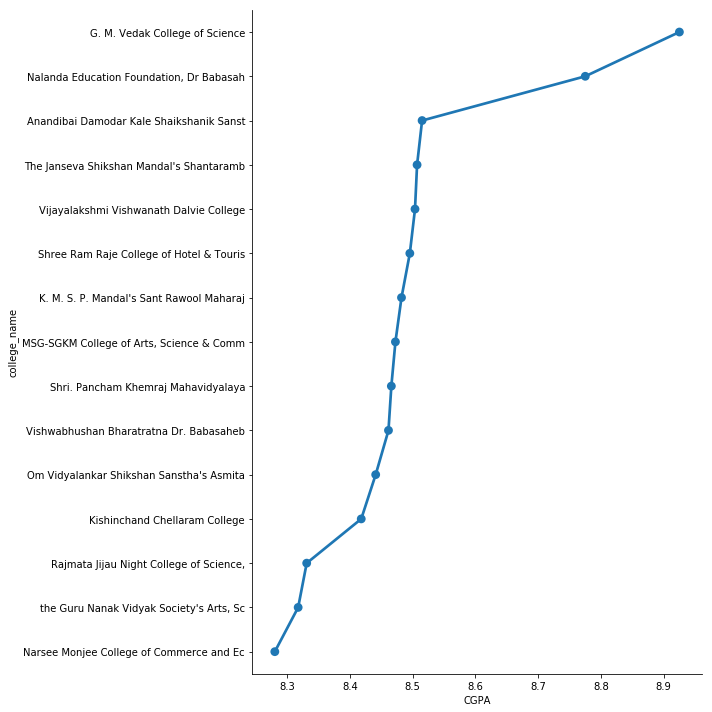

In [228]:
print_title("Top 15 Colleges ranked by MEAN CGPA")
# top_colleges_by_cgpa = colleges_df.sort_values(by='CGPA',ascending=True).head(100).reset_index()

# ts = top_colleges_by_cgpa.groupby(by='college_name').college_name.count().sort_values()
# ts = pd.DataFrame({'collage_name':ts.index,'Number of students':ts.values})


groupby_colleges_means = colleges_df.groupby(by='college_name').mean().sort_values(by='CGPA',ascending=False).reset_index()
top_15_colleges_by_means = groupby_colleges_means.head(15)
styled_ccm_df = highlight_value(top_15_colleges_by_means.loc[:,['college_name','CGPA']])
display(styled_ccm_df)

g = sns.catplot(y='college_name',x='CGPA',data=ccm_df,height=10,kind='point')

ruparel_college_group = groupby_colleges_means[groupby_colleges_means['college_name'] == COLLEGE_NAME]
ruparel_rank = ruparel_college_group.index.to_list()[0]
ruparel_cgpa_mean = ruparel_college_group.CGPA.to_list()[0]
print_title(f"Ruparel is ranked at {ruparel_rank}, With CGPA of {ruparel_cgpa_mean}")

,college_name,CGPA
0,G. M. Vedak College of Science,8.885000
1,"Nalanda Education Foundation, Dr Babasah",8.775000
2,The Janseva Shikshan Mandal's Shantaramb,8.740000
3,"Rajmata Jijau Night College of Science,",8.730000
4,"MSG-SGKM College of Arts, Science & Comm",8.660000
5,Shree Ram Raje College of Hotel & Touris,8.630000
6,Anandibai Damodar Kale Shaikshanik Sanst,8.625000
7,Vijayalakshmi Vishwanath Dalvie College,8.550000
8,K. M. S. P. Mandal's Sant Rawool Maharaj,8.500000
9,Vishwabhushan Bharatratna Dr. Babasaheb,8.495000


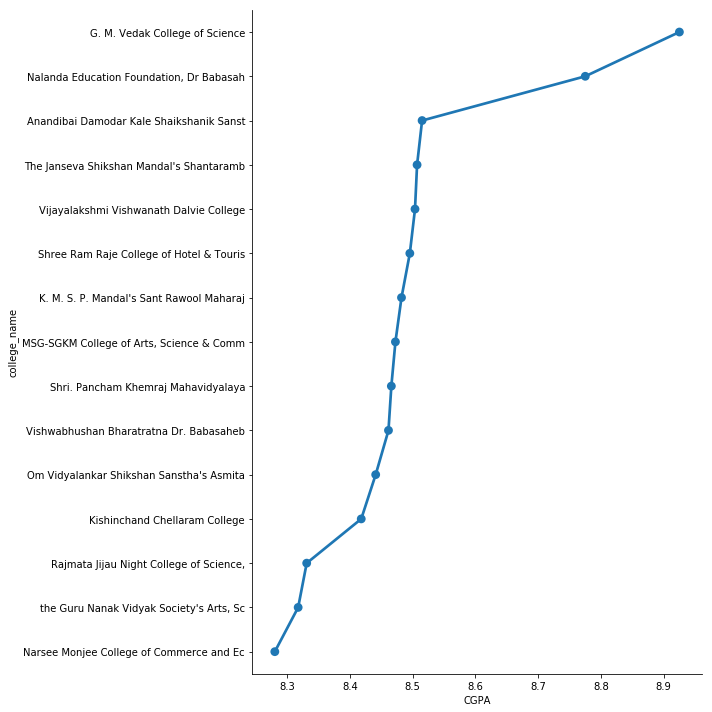

In [229]:
print_title("Top 15 Colleges ranked by MEDIAN CGPA")
# top_colleges_by_cgpa = colleges_df.sort_values(by='CGPA',ascending=True).head(100).reset_index()

# ts = top_colleges_by_cgpa.groupby(by='college_name').college_name.count().sort_values()
# ts = pd.DataFrame({'collage_name':ts.index,'Number of students':ts.values})


groupby_colleges_medians = colleges_df.groupby(by='college_name').median().sort_values(by='CGPA',ascending=False).reset_index()
top_15_colleges_by_medians = groupby_colleges_medians.head(15)
styled_ccm_df = highlight_value(top_15_colleges_by_medians.loc[:,['college_name','CGPA']])
display(styled_ccm_df)

g = sns.catplot(y='college_name',x='CGPA',data=ccm_df,height=10,kind='point')

ruparel_rank = groupby_colleges_medians[groupby_colleges_medians['college_name'] == COLLEGE_NAME].index.to_list()[0]
print_title(f"Ruparel is ranked at {ruparel_rank} with respect to Median CGPA")

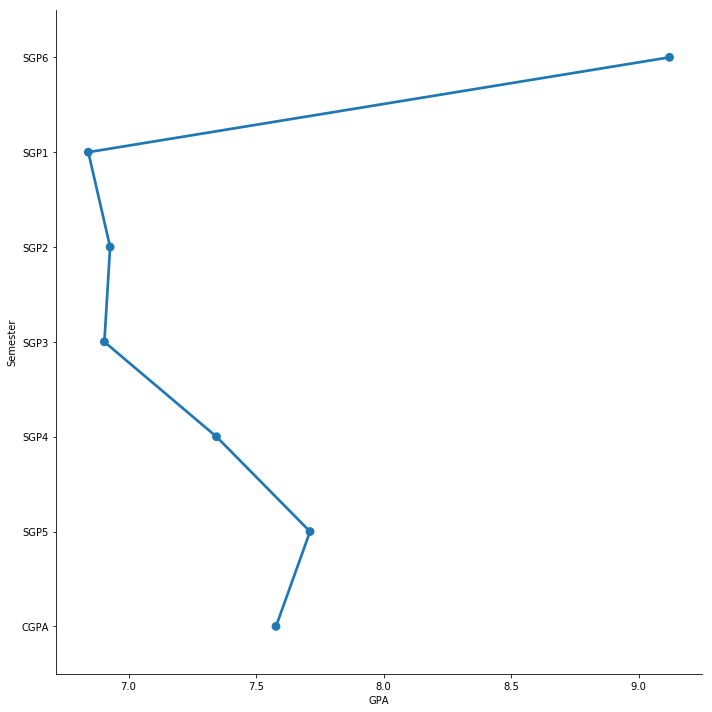

In [232]:
print_title("Average of SGPA's across All Students.")

overall_gpa_means = colleges_df.groupby(by='college_name').mean().mean()
d = overall_gpa_means.to_frame().reset_index().rename(columns={'index':'Semester',0:'GPA'})

print_caption("Note the sudden rise in mean SGPA for Semester 6.")
d = sns.catplot(x='GPA',y='Semester',data=d,kind='point',height=10)
